# Basic data operations
[Standard xarray calls](https://docs.xarray.dev/en/stable/user-guide/indexing.html) can be used for indexing, selecting from, and manipulating the DataArray. 

In [1]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os

# Set default options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Get ureg for pints units
import pint_xarray
ureg = pint_xarray.unit_registry
import pint

In [2]:
# Load some example data
from peaks.core.utils.sample_data import ExampleData
disp1 = ExampleData.dispersion
dt = xr.DataTree()
dt.add(ExampleData.dispersion, name='disp1')
dt.add(ExampleData.gold_reference, name = 'gold')

i05-59819.nxs:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

i05-59853.nxs:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

Basic arithmetic operations are supported. However, be careful to treat units properly using :class:`pint`, with the unit registry accessible as `pks.ureg`. For example, to subtract a constant from a :class:`xarray.DataArray`: 

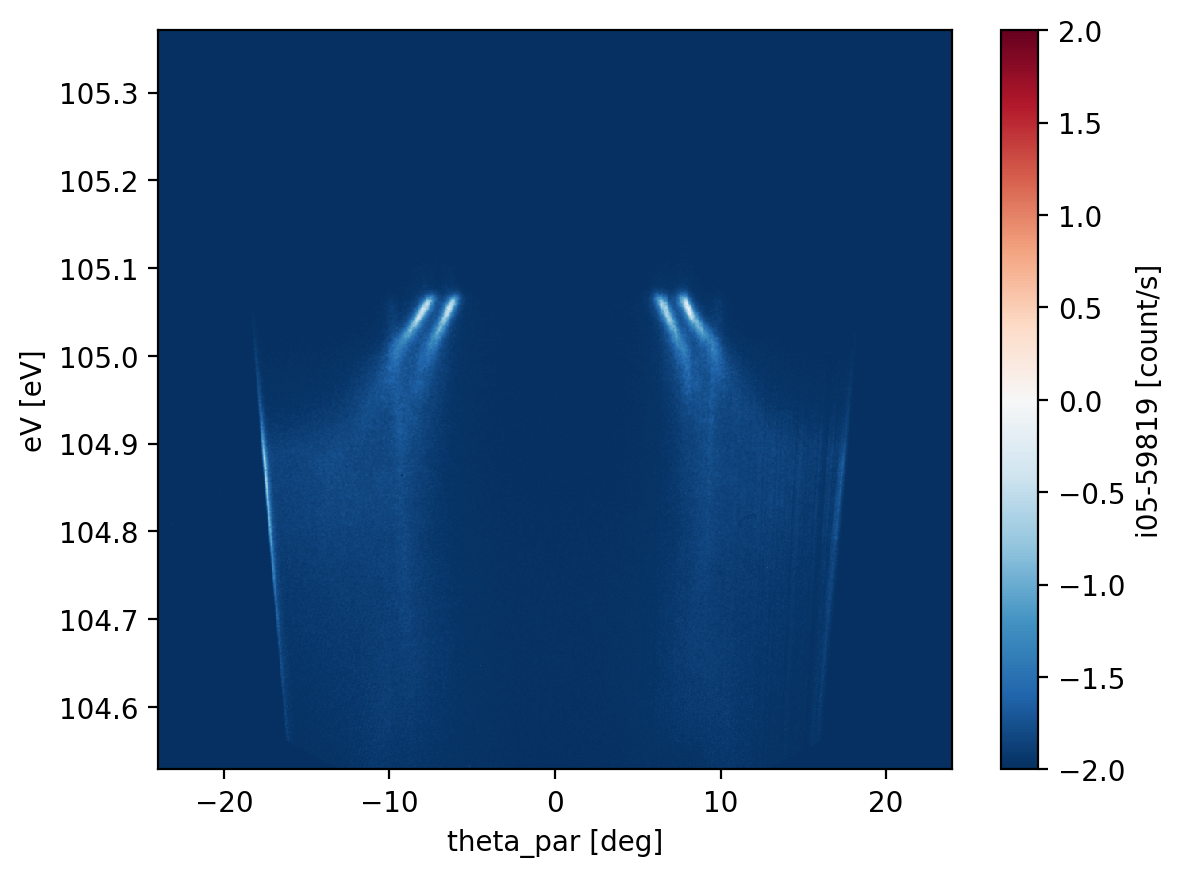

In [3]:
(disp1-(2*pks.ureg('count/s'))).plot()

## Summing and subtracting data
To sum two or more scans together, use `pks.sum_data(data_to_sum)` where `data_to_sum` is a list of the :class:`xarray.DataArray`s to sum together. `.sum_data` can also be called directly on a :class:`xarray.DataTree` to sum all leaf nodes of the tree. 

:::{admonition} Mismatched co-ordinates and metadata
:class: warning

While you can sum or subtract two DataArrays using simple arithmetic operations, often the underlying :class:`xarray.DataArray`s may have small numerical differences in the relevant scales, and will have different metadata. For this reason, and to maintain a transparent analysis history record, it is recommended to use the built in `peaks` functions. Data will be interpolated onto exactly the same data grid, although you should in general only pass :class:`xarray.DataArray`s which are already measured on nominally the same grid.
:::

In [4]:
sum_scan = dt.sum_data()

<div class="alert alert-block alert-danger"><b>Analysis info: </b> The following attributes of scan i05-59819 do not match those of scan i05-59853: 
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>manipulator</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>polar</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>value</strong></td><td>1.5015242916799991 deg&nbsp;&nbsp; || &nbsp;&nbsp;0.0015242955199994415 deg</td></tr></table></td></tr><tr><td><strong>x2</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>value</strong></td><td>0.278 mm&nbsp;&nbsp; || &nbsp;&nbsp;0.924 mm</td></tr></table></td></tr><tr><td><strong>x1</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>value</strong></td><td>1.09 mm&nbsp;&nbsp; || &nbsp;&nbsp;0.671 mm</td></tr></table></td></tr><tr><td><strong>azi</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>value</strong></td><td>-12.510000138999999 deg&nbsp;&nbsp; || &nbsp;&nbsp;17.48571448 deg</td></tr></table></td></tr><tr><td><strong>tilt</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>value</strong></td><td>0.006 deg&nbsp;&nbsp; || &nbsp;&nbsp;0.0 deg</td></tr></table></td></tr><tr><td><strong>x3</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>value</strong></td><td>-2.8659999999999854 mm&nbsp;&nbsp; || &nbsp;&nbsp;-36.29200000000003 mm</td></tr></table></td></tr></table></td></tr><tr><td><strong>photon</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>exit_slit</strong></td><td>0.01 mm&nbsp;&nbsp; || &nbsp;&nbsp;0.1 mm</td></tr><tr><td><strong>hv</strong></td><td>109.999792 eV&nbsp;&nbsp; || &nbsp;&nbsp;109.99993499999998 eV</td></tr></table></td></tr><tr><td><strong>temperature</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>shield</strong></td><td>59.4714 K&nbsp;&nbsp; || &nbsp;&nbsp;61.6002 K</td></tr><tr><td><strong>cryostat</strong></td><td>10.7334 K&nbsp;&nbsp; || &nbsp;&nbsp;11.1745 K</td></tr><tr><td><strong>sample</strong></td><td>11.9915 K&nbsp;&nbsp; || &nbsp;&nbsp;12.4563 K</td></tr></table></td></tr><tr><td><strong>analyser</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>scan</strong></td><td>
                <style>
                    table { border-collapse: collapse; }
                    td, th { padding: 2px 5px; margin: 0; border: 1px solid black; }
                </style>
                <table>
                <tr><td><strong>sweeps</strong></td><td>600&nbsp;&nbsp; || &nbsp;&nbsp;300</td></tr></table></td></tr></table></td></tr></table> Attributes of scan i05-59819 kept. </div>

A similar method, `subtract_data`, exists to subtract two scans. Note, in this case, a list of 2 scans should be passed, or `.subtract_data` should be called on a :class:`xarray.DataTree` with only two leaf nodes containing data. Warnings of mismatched metadata can also be suppressed via the `quiet=` flag.

In [5]:
diff_scan = dt.subtract_data(quiet=True)

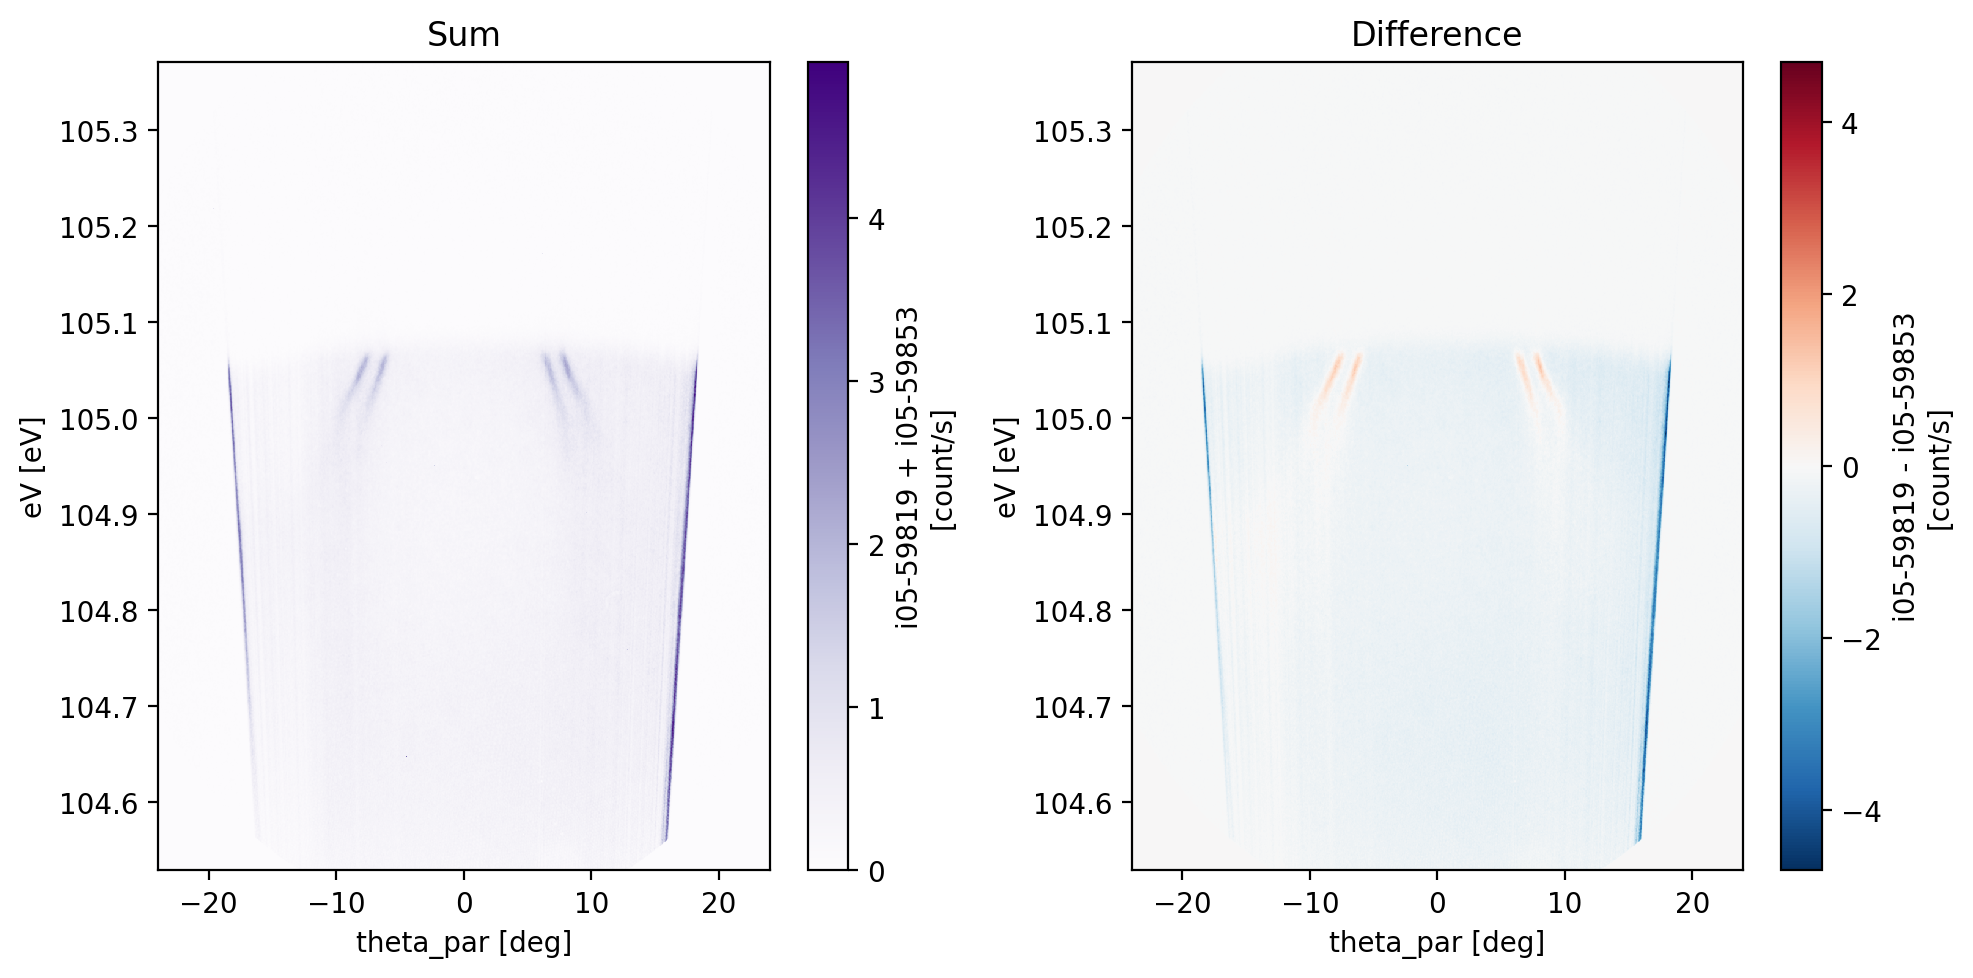

In [6]:
pks.plot_grid([sum_scan,diff_scan], titles=['Sum','Difference'])

## Selecting from data
Data can be selected using `.sel` and averaged using `.mean`:

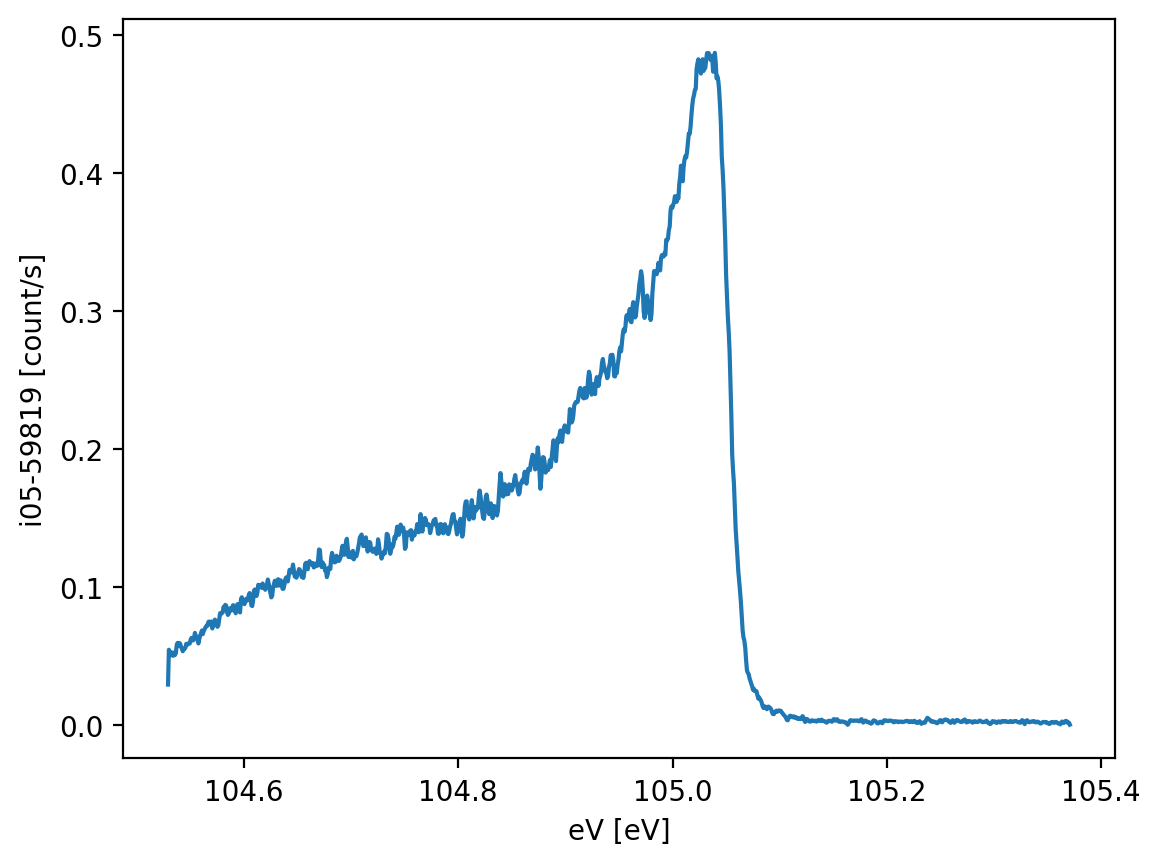

In [7]:
disp1.sel(theta_par=slice(-10,-8)).mean('theta_par').plot()

It is also possible to select with [unit-full indexing](https://xarray.dev/blog/introducing-pint-xarray) using `pint-xarray`, passing the units as either `pint.Unit`s or via the unit-registry

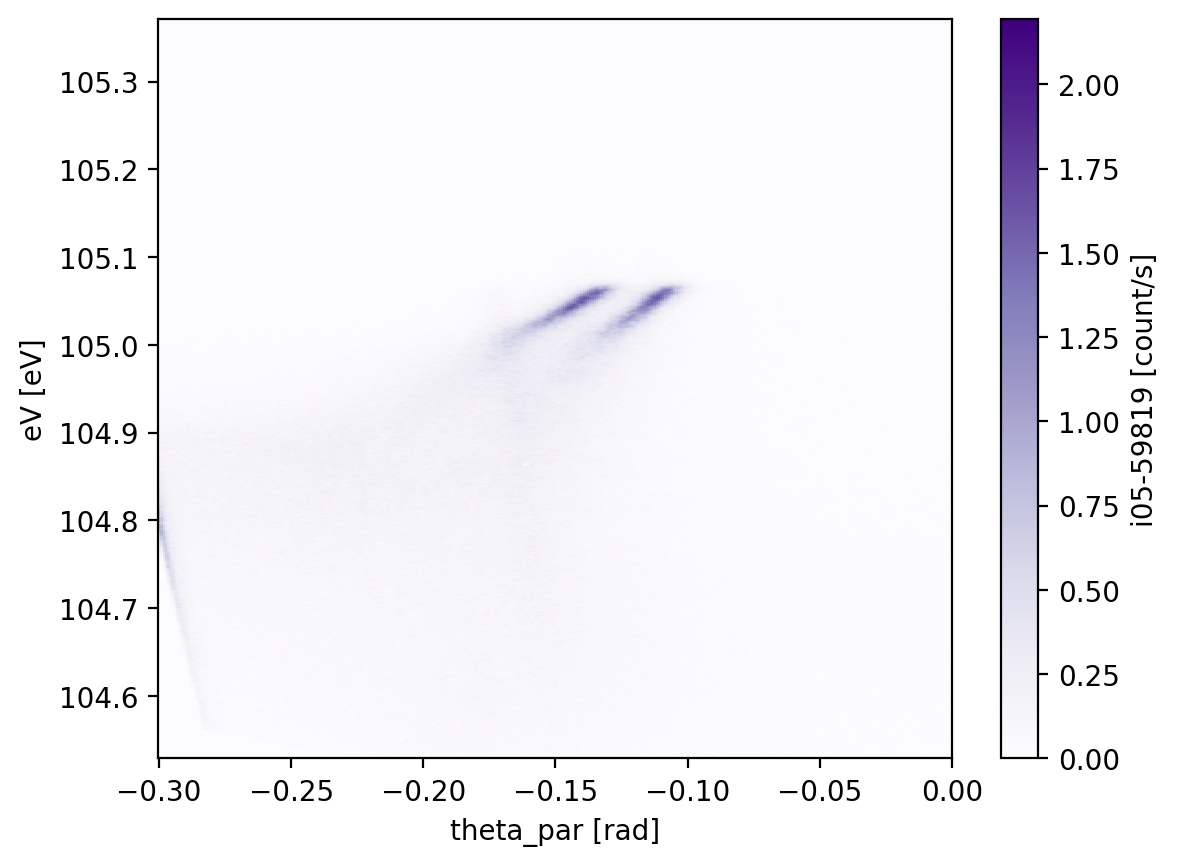

In [8]:
disp1.pint.sel(theta_par=slice(-0.3*pks.ureg.radians,0)).plot()

:::{admonition}Broadcasting across DataTrees
:class: tip

Many of the in-built :class:`xarray.DataArray` methods, as well a significant number of the `peaks` data selection and processing functions will broadcast when applied to a :class:`xarray.DataTree`, returning another :class:`xarray.DataTree` with the relevant function applied. This can be useful for batch processing of data. Some examples are given below.
:::

### EDC and MDC extraction
Helper functions exist for quick extraction of one or an array of EDCs and MDCs, including optional integration. These can be applied directly to :class:`xarray.DataArrays`

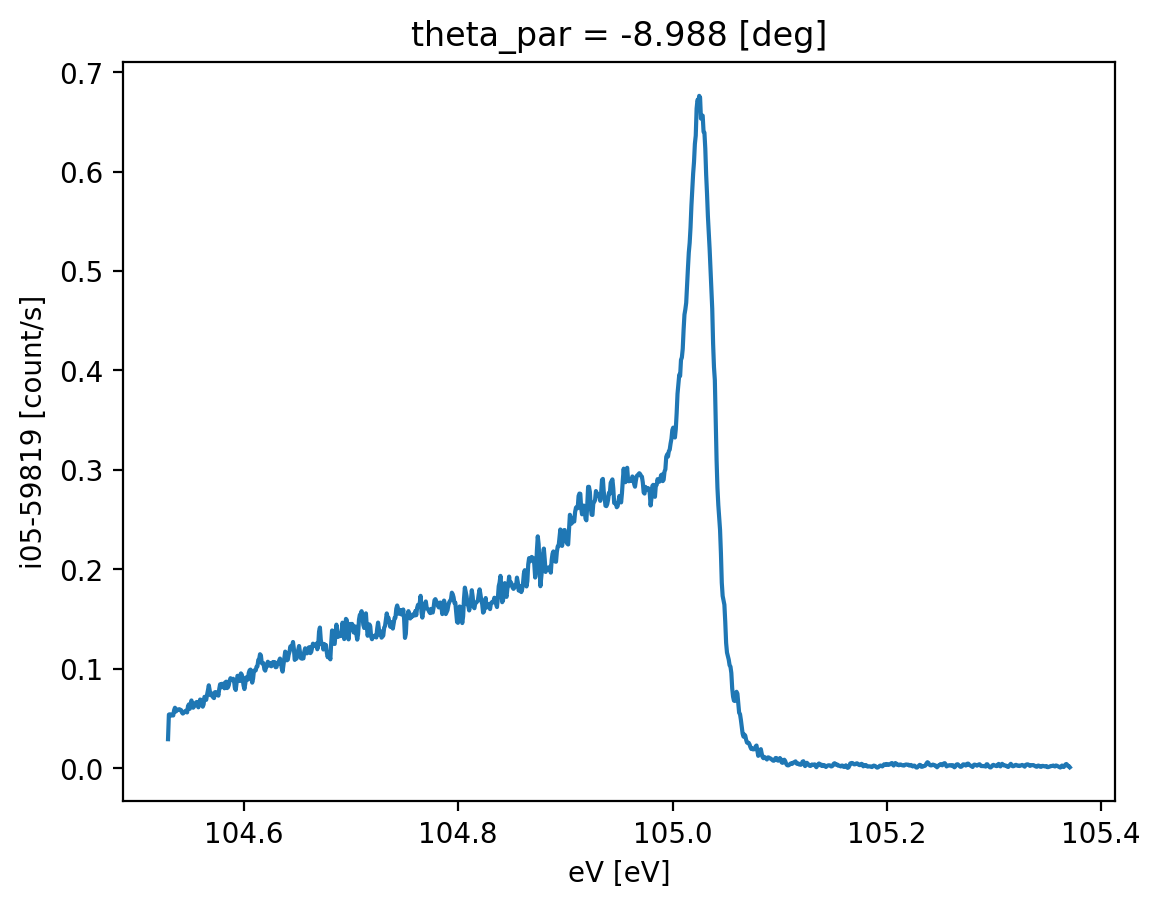

In [9]:
disp1.EDC(-9, 1).plot()

Or can be applied to a :class:`xarray.DataTree` to return a new :class:`xarray.DataTree` with the same DC extracted from each scan 

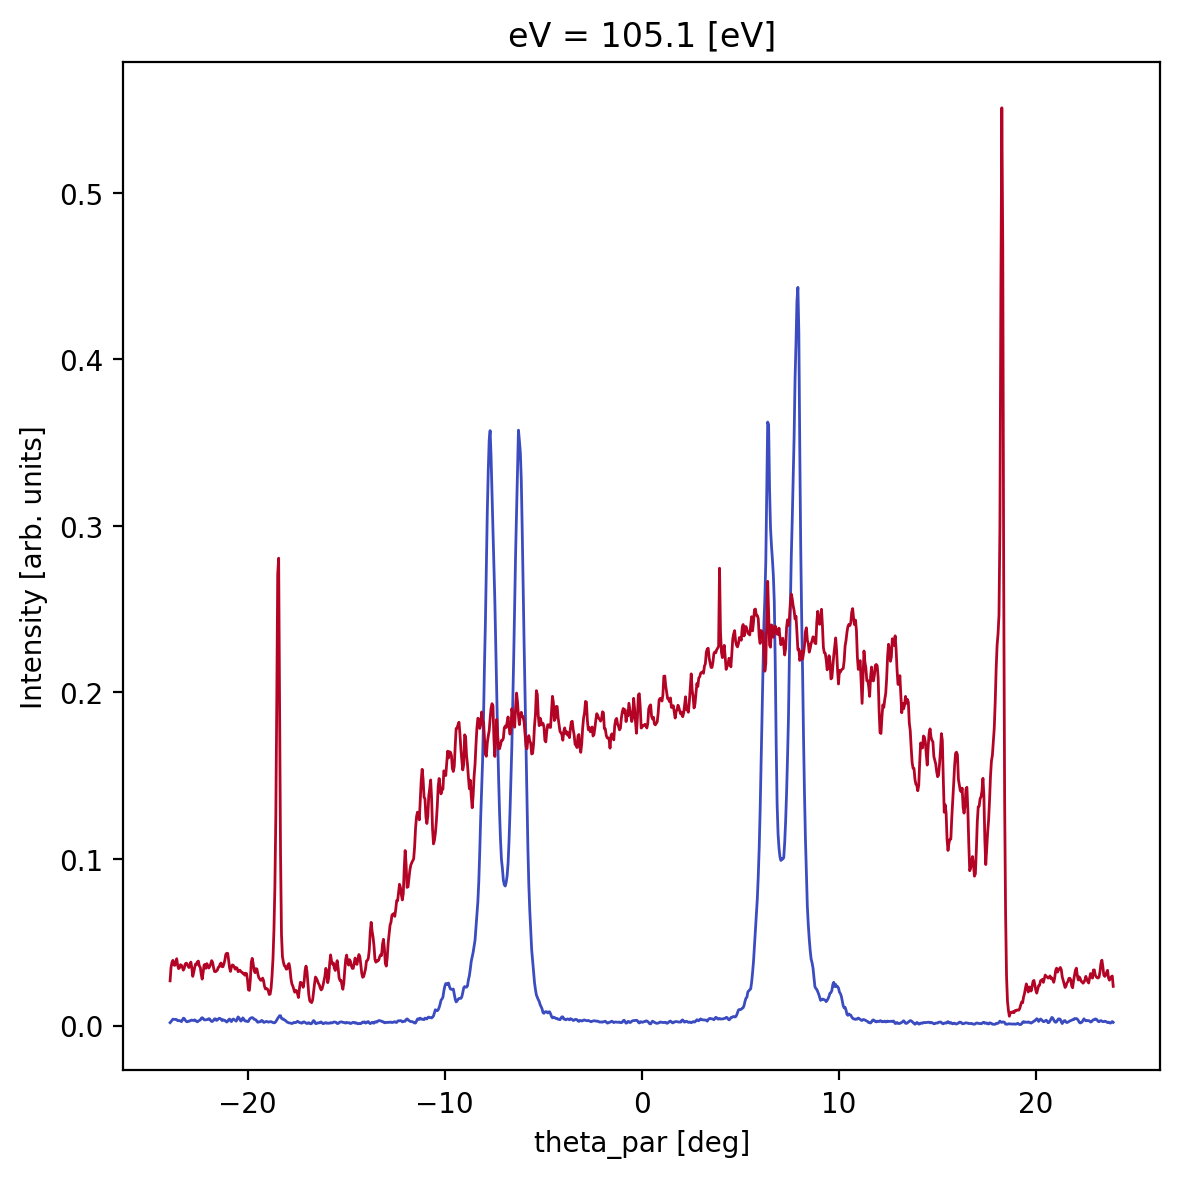

In [10]:
dt.MDC(105.08,0.05).plot_DCs(x='theta_par')

Multiple DCs can be extracted from a single scan

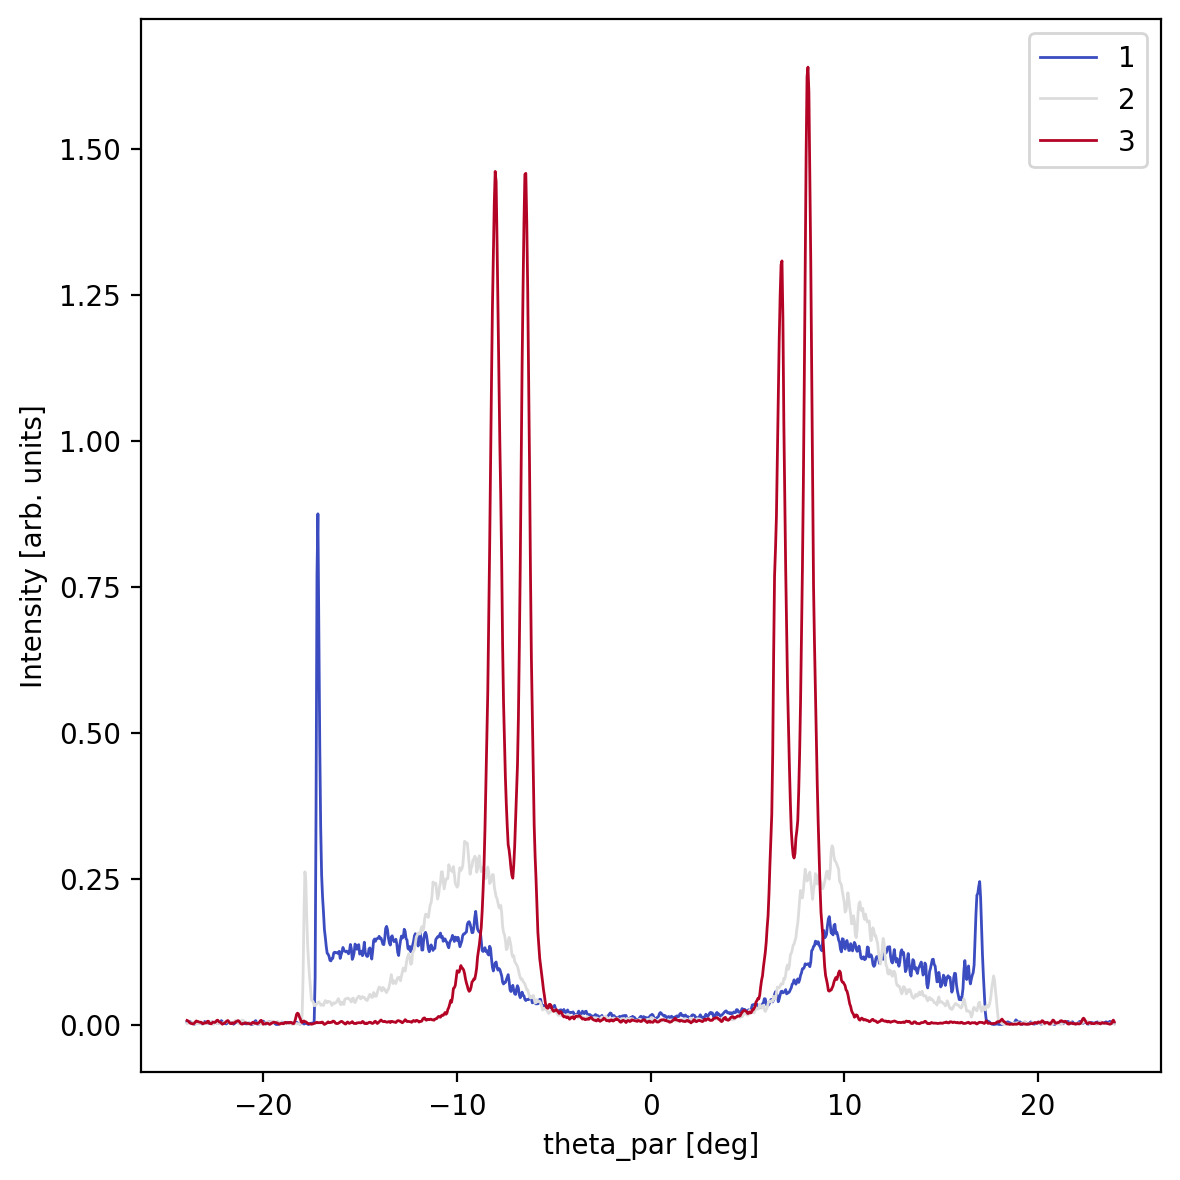

In [11]:
MDCs = disp1.MDC([104.8,104.95,105.05],0.01)
pks.plot_DCs(MDCs, titles=['1','2','3'])  # Plot the extracted DCs

The DC-type methods can be applied to higher-dimensional data, e.g. to extract a Fermi surface:

i05-59818.nxs:   0%|          | 0.00/107M [00:00<?, ?B/s]

[########################################] | 100% Completed | 6.82 s


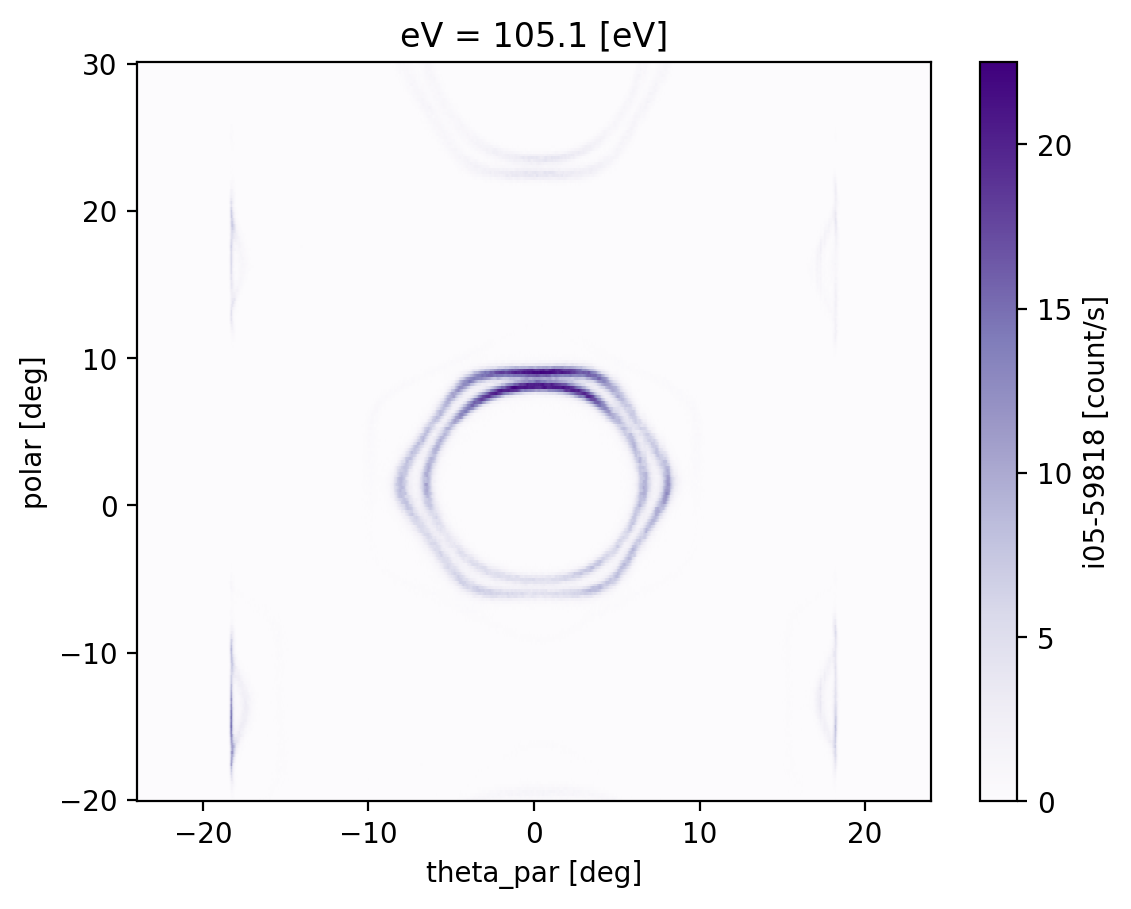

In [12]:
FS1 = ExampleData.FS
FS1.MDC(105.05,0.02).plot()

:::{tip}
The function `.DC` is the underlying function called by the `MDC` and `EDC` methods. This can be called directly, allowing EDC and MDC-like functionality to be applied to extract a slice along any dimension from a :class:`xarray.DataArray` with arbitrary dimensions.
:::

### Extracting arbitrary cuts
For extraction of a single cut between a single start and end point (MDCs, dispersions, or in principle any slice of an arbitrary dimensional array between start and end points defined in two dimensions), the `.extract_cut` method can be used.

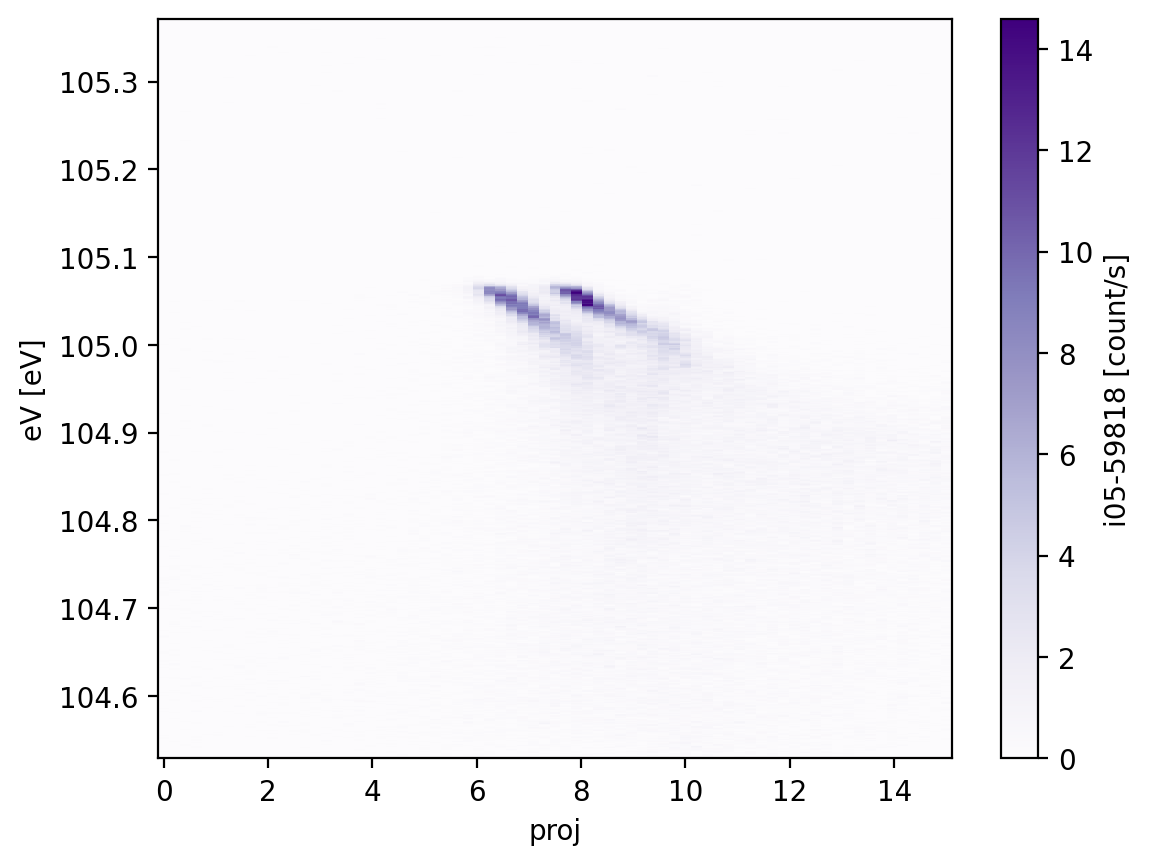

In [13]:
# Extract a dispersion from a FS data cube
cut = FS1.extract_cut(start_point={'theta_par':0, 'polar': 1.5},
                          end_point={'theta_par':15, 'polar': 1.5})
cut.plot()

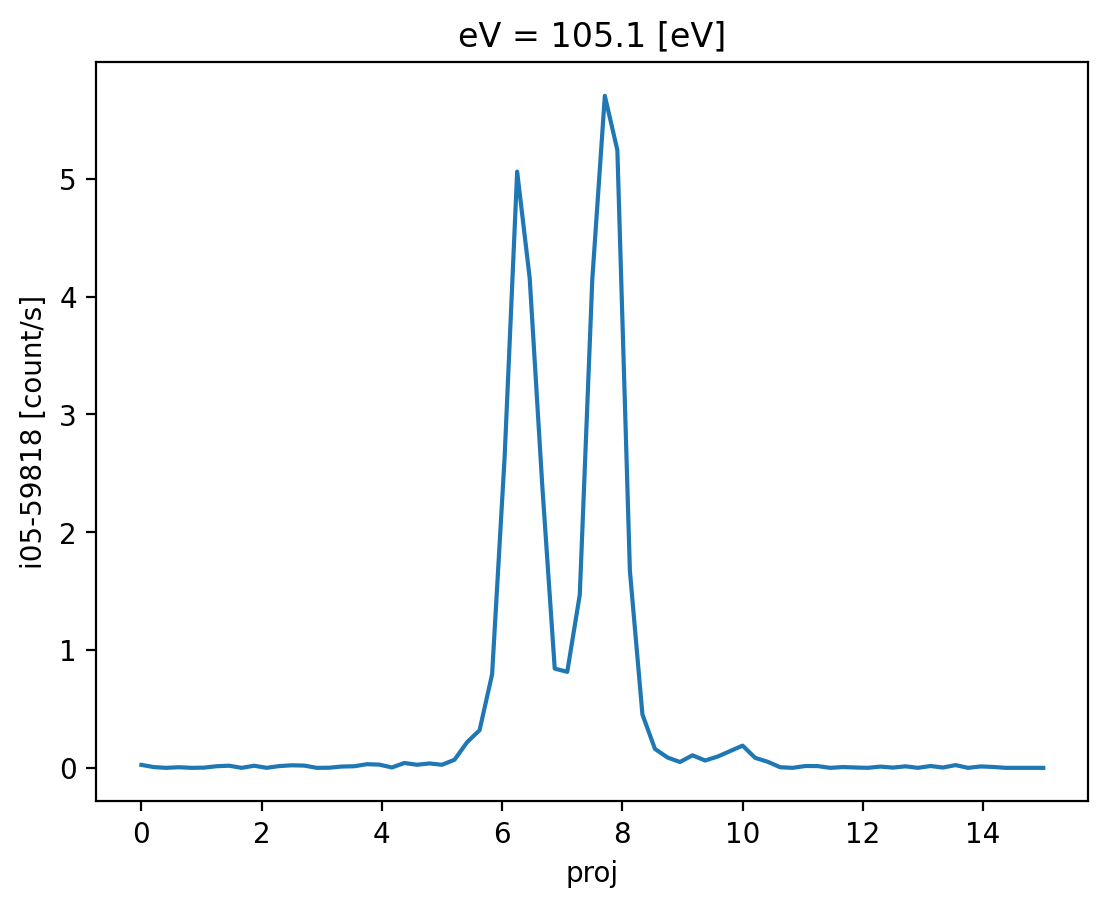

In [14]:
# Extract an arbitrary cut from an energy slice
FSM = FS1.MDC(105.067, 0.01)
# Extract the MDC between the same start and end points as above
FSM.extract_cut(start_point={'theta_par':0, 'polar': 1.5},
                          end_point={'theta_par':15, 'polar': 1.5}).plot()

### Radial cuts
A special helper function, `.radial_cuts`, exists to take a series of these cuts as radial cuts of some radius around a single point

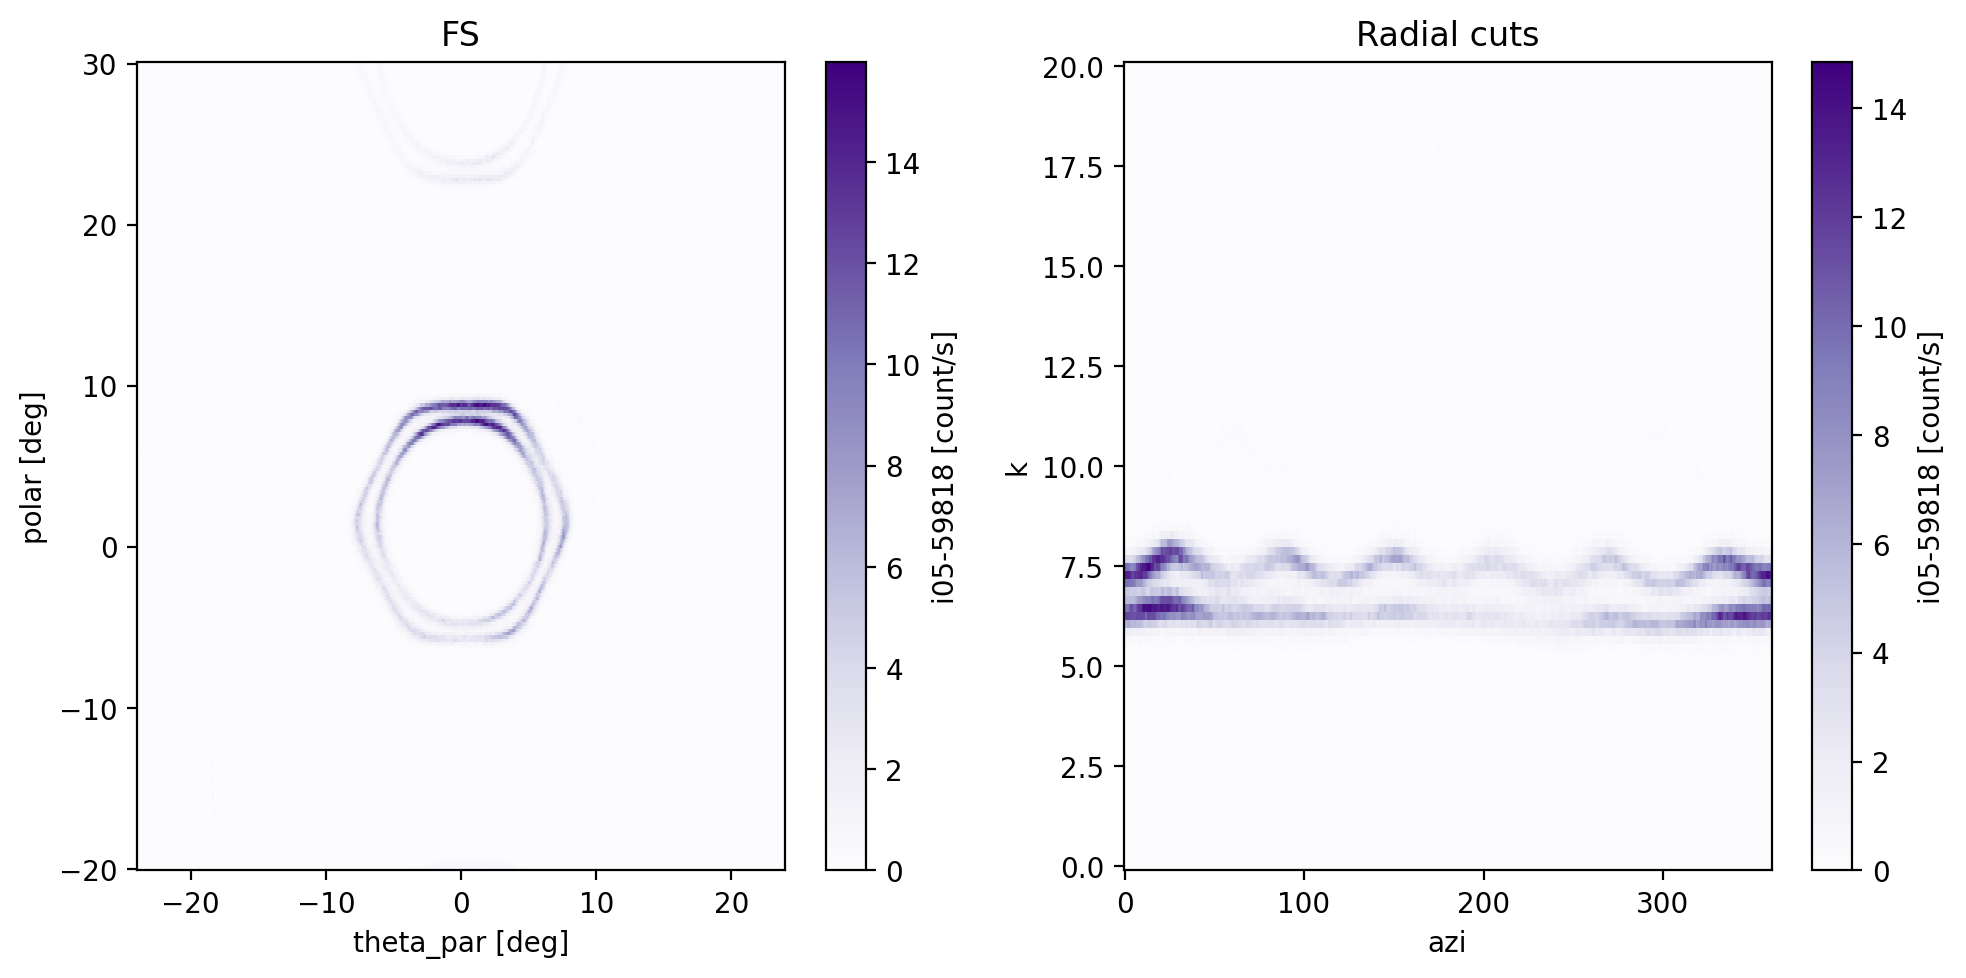

In [15]:
cuts = FSM.radial_cuts(radius=20,  # radius of the cuts
                       polar=1.5,  # centre co-ordinates
                       num_points=100)
pks.plot_grid([FSM,cuts],
             titles=["FS","Radial cuts"])

The `.radial_cuts` can be used on any :class:`xrray.DataArray` which has two angle or momentum directions (which are assumed to have the same units). If an energy dimension is also present, the interpolation will be broadcast over the energy dimension.

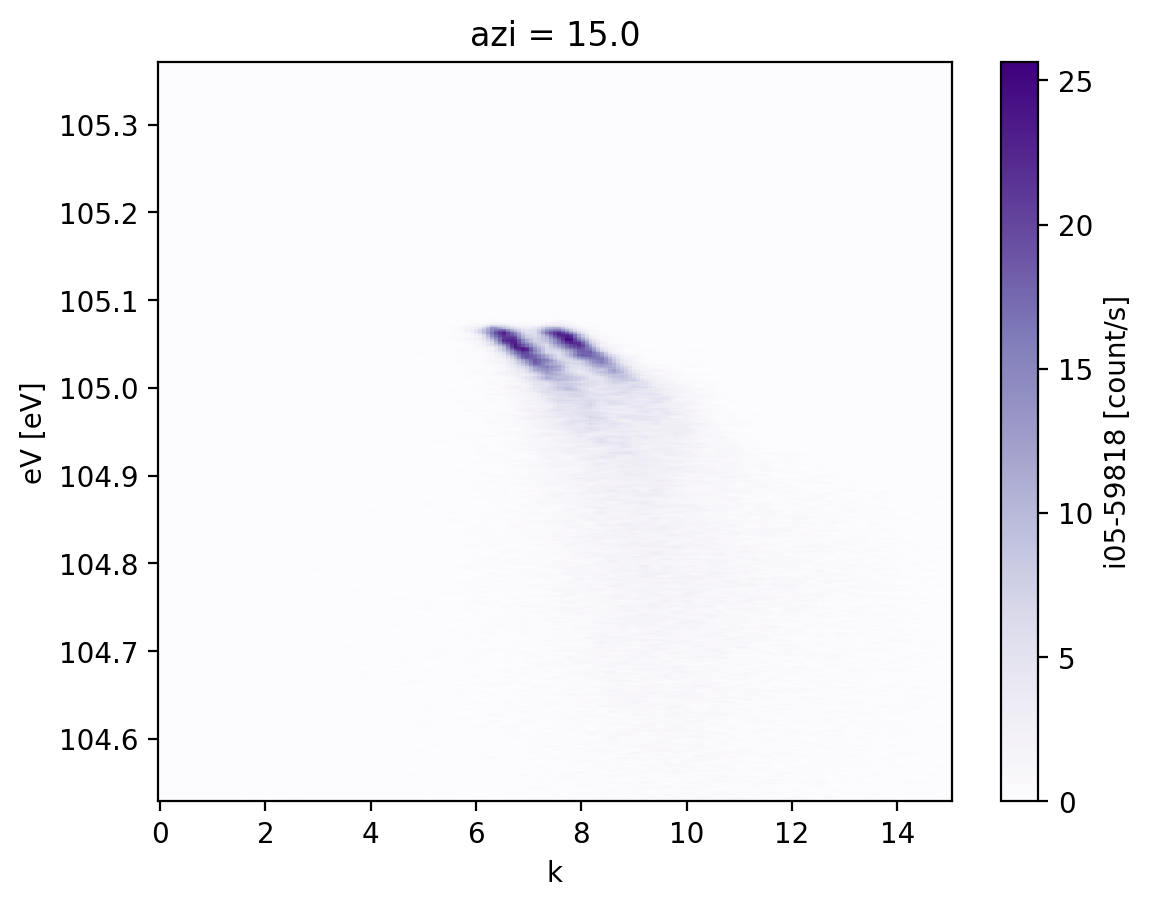

In [16]:
# Now passing the full 3D array
ang_slices = FS1.radial_cuts(radius=15,  # radius of the cuts
                       polar=1.5,  # centre co-ordinates
                       num_points=201)

# Select a single azimuth value to plot
ang_slices.isel(azi=15).plot()

:::{note}
In principle, these function will accept :class:`xarray.DataArray`'s backed by :class:`dask.array.core.Array` arrays. This appears to work for the `.extract_cut` function above, however, appears unstable at present for `.radial_cuts` and requires further testing. In case of problems, it is currently recommended to run `.compute()` before passing to the `.radial_cuts` function.
:::